# SWAG-P Simulation with Gap Plasmon Explorer

#### GP Explorer is a handly tools allowing to manipulate GP geometries and visualize its reflectance under differents configurations. 
#### Then, GP influence on reflectance from red-shift to Fano profils can be studying without programming skills.

To begin, remember that a GP<sup><a href="#note1">[1]</a></sup> -a guided electromagnetic wave into dielectric-, must be undertand as a mode of the nano cavity -the so called "gap"- between two close metallic regions. As it confines light more than surface plasmon, GPs are even more sensible to non-locality influence. GPs depends obviously on spaces fields variations, the currents density generalized into non local form shows how conductivities becomes a space respons function describing how the surrounding fields influence currents at any points. Consequencies is the space broadening of the electromagnetic fields. In others words, at path means free scale of electrons, the fields scattering reduces the field intensities into the nano-gap. Then taking into account non locality, a blue-shift can be observed.  





<p id="note1"><b>[1]</b> A solution of Maxwell's equations without source.</p>

In [ ]:
import sys, os
# Ajouter le chemin vers le dossier 'modules'
module_path = os.path.abspath(os.path.join('/home/chardon-grossard/Bureau/SWAG-P/Gap_Plasmon_2D/Workspace/', 'modules'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import matplotlib.pyplot as plt


from Functions_materials_models_dispertion import faddeeva

In [17]:
# Définir le chemin relatif vers le fichier JSON (en supposant que le dossier 'data' se trouve au même niveau que 'modules')
json_path = os.path.abspath(os.path.join('/home/chardon-grossard/Bureau/SWAG-P/Gap_Plasmon_2D/Workspace/', 'data', 'material_data.json'))

print("Chemin vers le fichier JSON :", json_path)

# Exemple d'utilisation avec get_n_k
from Functions_get_n_k_materials import get_n_k # importe fonctions pour récup n et k


Chemin vers le fichier JSON : /home/chardon-grossard/Bureau/SWAG-P/Gap_Plasmon_2D/Workspace/data/material_data.json


In [3]:
material_test = "SiA"
lambda_test = 500  # en nm

# récupérer n et k
n_val, k_val = get_n_k(material_test, lambda_test, json_path)
print(f"For {material_test} at {lambda_test} nm: n = {n_val:.6f}, k = {k_val:.6f}")

For SiA at 500 nm: n = 4.467695, k = 1.090821


In [ ]:
from Brendel_Bormann import BrendelBormann
from MaterialsLoader import load_materials, get_material_params

# Charger le fichier JSON des matériaux
materials_data = load_materials()

# Sélection du matériau
selected_material = "Au"  # Changer selon le besoin
f0, omega_p, Gamma0, f, omega, gamma, sigma = get_material_params(selected_material, materials_data)

lambda_range = np.linspace(300, 2000, 500)  # nm
epsilon_selected = np.empty_like(lambda_range, dtype=complex)

for idx, wavelength in enumerate(lambda_range):
    epsilon_selected[idx] = BrendelBormann(wavelength, f0, omega_p, Gamma0, f, omega, gamma, sigma)



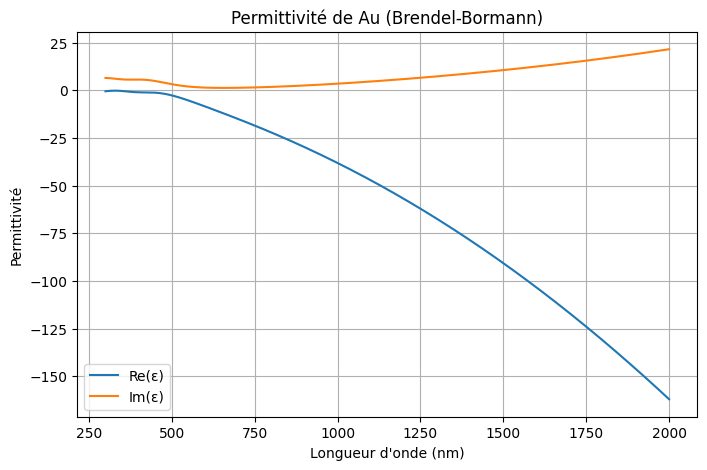

In [12]:
# Définir la plage de longueurs d'onde (en nm)
lambda_range = np.linspace(300, 2000, 500)

# Tracé du résultat
plt.figure(figsize=(8, 5))
plt.plot(lambda_range, np.real(epsilon_selected), label="Re(ε)")
plt.plot(lambda_range, np.imag(epsilon_selected), label="Im(ε)")
plt.xlabel("Longueur d'onde (nm)")
plt.ylabel("Permittivité")
plt.title(f"Permittivité de {selected_material} (Brendel-Bormann)")
plt.legend()
plt.grid()
plt.show()

In [13]:
# Charger les paramètres pour les matériaux Ag et Au
f0_Ag, omega_p_Ag, Gamma0_Ag, f_Ag, omega_Ag, gamma_Ag, sigma_Ag = get_material_params("Ag", materials_data)
f0_Au, omega_p_Au, Gamma0_Au, f_Au, omega_Au, gamma_Au, sigma_Au = get_material_params("Au", materials_data)


In [14]:
# Paramètres fixes pour la structure SWAG
geometry = {
    "thick_super": 200,
    "width_reso": 30,
    "thick_reso": 30,
    "thick_gap": 3,
    "thick_func": 1,
    "thick_mol": 2,
    "thick_metalliclayer": 10,
    "thick_sub": 200,
    "thick_accroche": 1,
    "period": 100.2153
}
angle = 0          # Incidence normale
polarization = 1   # 1 pour TM, 0 pour TE
n_val, k_val = 1.5, 0.1  # Exemple : indice et extinction du substrat
perm_sub = (n_val + 1j * k_val) ** 2
perm_env = 1.0
perm_dielec = 1.45 ** 2

In [ ]:
# Préparer le dictionnaire de matériaux (les valeurs pour Ag et Au seront calculées pour chaque wavelength)
materials = {
    "perm_env": perm_env,
    "perm_dielec": perm_dielec,
    "perm_sub": perm_sub,
    "perm_reso": None,           # sera mis à jour avec Ag
    "perm_metalliclayer": None,   # sera mis à jour avec Au
    "perm_accroche": None         # idem
}

# Initialiser le dictionnaire d'onde
wave = {"wavelength": None, "angle": angle, "polarization": polarization}
n_mod = 100

# Listes pour stocker les résultats de réflectance
Rup_values = []
Rdown_values = []


In [16]:
from Functions_RCWA import cascade, c_bas, c_haut, intermediaire, couche, step, grating, homogene, interface, HErmes
from Function_reflectance_SWAG import reflectance

for wavelength in lambda_range:
    # Calculer les permittivités pour chaque matériau avec la fonction BrendelBormann
    perm_Ag = BrendelBormann(wavelength, f0_Ag, omega_p_Ag, Gamma0_Ag, f_Ag, omega_Ag, gamma_Ag, sigma_Ag)
    perm_Au = BrendelBormann(wavelength, f0_Au, omega_p_Au, Gamma0_Au, f_Au, omega_Au, gamma_Au, sigma_Au)
    
    # Mise à jour du dictionnaire des matériaux
    materials["perm_reso"] = perm_Ag
    materials["perm_metalliclayer"] = perm_Au
    materials["perm_accroche"] = perm_Au  # Ou adapter selon votre besoin
    
    # Mise à jour de la longueur d'onde dans le dictionnaire d'onde
    wave["wavelength"] = wavelength
        # Calcul de la réflectance via votre fonction reflectance du module SWAG
    Rup, Rdown = reflectance(geometry, wave, materials, n_mod)
    
    Rup_values.append(Rup)
    Rdown_values.append(Rdown)


print("Réflectance R_up :", Rup)
print("Réflectance R_down :", Rdown)

Réflectance R_up : 0.7889022906353655
Réflectance R_down : 0.5438364789308106


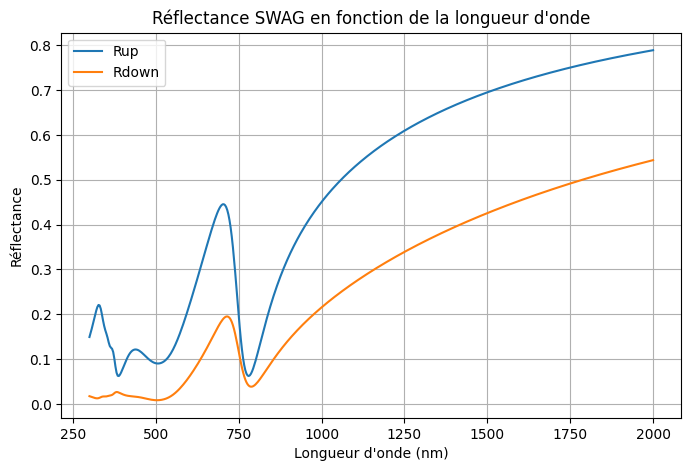

In [18]:
# Tracé des résultats
plt.figure(figsize=(8, 5))
plt.plot(lambda_range, Rup_values, label="Rup")
plt.plot(lambda_range, Rdown_values, label="Rdown")
plt.xlabel("Longueur d'onde (nm)")
plt.ylabel("Réflectance")
plt.title("Réflectance SWAG en fonction de la longueur d'onde")
plt.legend()
plt.grid()
plt.show()